# **DETECTION**

- Use trained YOLO-v3-A# models to detect PPE attire

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython.display import display, Math
from time import time

import sys
sys.path.append('../')

from src.utils.image import letterbox_image, draw_detection
from src.yolo3.model import yolo_body

from src.utils.fixes import *
fix_tf_gpu()

## **YOLO MODEL**

### Configuaration

In [2]:
class_names = ['H', 'V', 'W']

anchor_boxes = np.array(
        [
        np.array([[ 76,  59], [ 84, 136], [188, 225]]) /32, # output-1 anchor boxes
        np.array([[ 25,  15], [ 46,  29], [ 27,  56]]) /16, # output-2 anchor boxes
        np.array([[ 5,    3], [ 10,   8], [ 12,  26]]) /8   # output-3 anchor boxes
        ],
        dtype='float64'
    )

input_shape  = (416, 416)

### Model

In [3]:
K.clear_session() # clear memory

# number of classes and number of anchors
num_classes = len(class_names)
num_anchors = anchor_boxes.shape[0] * anchor_boxes.shape[1]

# input and output
input_tensor = Input( shape=(input_shape[0], input_shape[1], 3) ) # input
num_out_filters = ( num_anchors//3 ) * ( 5 + num_classes )        # output

# build the model
model = yolo_body(input_tensor, num_out_filters)

### Load weights

In [4]:
weight_path = '../model-data/weights/pictor-ppe-v302-a1-yolo-v3-weights.h5'

model.load_weights( weight_path )

## **PREDICTION**

### Load an test image

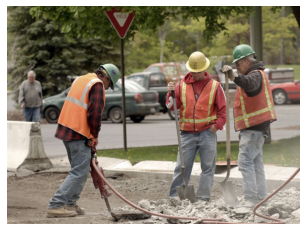

In [5]:
act_img = cv2.imread('../extras/sample-images/0.JPG')
image_shape = act_img.shape[:-1]
img = letterbox_image(act_img, (416,416))/255.
img = np.expand_dims(img, 0)

'''Show the image'''
plt.imshow( act_img[:,:,::-1] )
plt.axis('off')
plt.show()

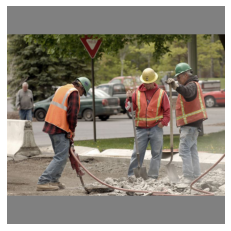

In [6]:
'''Show the letterbox image'''
plt.imshow( letterbox_image(act_img, (416,416))[:,:,::-1] )
plt.axis('off')
plt.show()

### Get prediction

In [7]:
yolo_pred = model.predict(img)

## **PREDICTED VALUES to DETECTED BOXES**

### Analyze the predicted values

- The predictions in each output layer is a 4-dimensional tensor with a shape of:  
( batch size, # grids in x-dir, # grids in y-dir, # anchor boxes in this layer * ( 5 + # classes ) )

In [8]:
for i in range( len(yolo_pred) ):
    print('Output-{} shape: '.format(i), yolo_pred[i].shape )

Output-0 shape:  (1, 13, 13, 24)
Output-1 shape:  (1, 26, 26, 24)
Output-2 shape:  (1, 52, 52, 24)


- Let's reshape it to a 5-dimensional tensor with a shape of:  
( batch size, # grids in x-dir, # grids in y-dir, # anchor boxes in this layer,  ( 5 + # classes ) )

In [9]:
pred = []
for i in range( len(yolo_pred) ):
    pred.append( yolo_pred[i].reshape( [-1, *yolo_pred[i].shape[1:3], 3, (5+num_classes) ] ) )
    
for i in range( len(yolo_pred) ):
    print('Output-{} shape: '.format(i), pred[i].shape )

Output-0 shape:  (1, 13, 13, 3, 8)
Output-1 shape:  (1, 26, 26, 3, 8)
Output-2 shape:  (1, 52, 52, 3, 8)


- Let's find which grid the in 1st output layer has the highest probability of presence of an object (a.k.a. objectness score)

In [10]:
grid_shape = pred[0].shape[1:3] # shape of the grids

obj_scores = pred[0] [0, :, :, :, 4] # objectness scores
grid_i, grid_j, abox_k = np.unravel_index( np.argmax( obj_scores, axis=None ), obj_scores.shape )

abox = anchor_boxes[0][abox_k] # corresponding anchor box

print( "Grid size: ({}, {})".format( *grid_shape ) )
print( "Most likely there is an object in grid ({}, {}) with anchor box of size {}".format( grid_i, grid_j, abox ) )

Grid size: (13, 13)
Most likely there is an object in grid (6, 10) with anchor box of size [2.625 4.25 ]


- Predicted raw values in one grid for one bounding box: ( $t_x$, $t_y$, $t_w$, $t_h$, $t_{p_0}$, $t_{p_1}$, ..., $t_{p_n}$ )

In [11]:
np.set_printoptions( precision=4 )

print( 'box parameters (x, y) : {}'.format( pred [0] [0, grid_i, grid_j, abox_k, 0:2] ) )
print( 'box parameters (w, h) : {}'.format( pred [0] [0, grid_i, grid_j, abox_k, 2:4] ) )
print( 'objectness score      : {}'.format( pred [0] [0, grid_i, grid_j, abox_k, 4:5] ) )
print( 'class probabilities   : {}'.format( pred [0] [0, grid_i, grid_j, abox_k, 5:5+num_classes] ) )

box parameters (x, y) : [1.4373 1.9136]
box parameters (w, h) : [-0.1141  0.5582]
objectness score      : [7.9478]
class probabilities   : [-13.2288 -10.1954  11.3023]


- Transformed values in one grid for one bounding box: ( $x$, $y$, $w$, $h$, $p_0$, $p_1$, ..., $p_n$ )  
coordinates of the center of the box: x, y = sigmoid($t_x$), sigmoid($t_y$)  
width and height of the box: w, h = exp($t_w$), exp($t_h$)  
objectness score: $p_0$ =  sigmoid($t_{p_0}$)  
class probabilities: $p_i$ =  sigmoid($t_{p_i}$) for $i$ = 1, ..., n

In [12]:
np.set_printoptions( precision=2, suppress=True )

# define the sigmoid function
sigmoid = lambda x : 1 / ( 1 + np.exp(-x) )

bx_xy     = sigmoid( pred [0] [0, grid_i, grid_j, abox_k, 0:2] ) # box's center (x and y)
bx_wh     = np.exp ( pred [0] [0, grid_i, grid_j, abox_k, 2:4] ) # box's width and height
obj_score = sigmoid( pred [0] [0, grid_i, grid_j, abox_k, 4:5] ) # objectness score
cls_probs = sigmoid( pred [0] [0, grid_i, grid_j, abox_k, 5:5+num_classes] ) # conditional class probabilities

print( 'box parameters (x, y) : {}'.format( bx_xy ) )
print( 'box parameters (w, h) : {}'.format( bx_wh ) )
print( 'objectness score      : {}'.format( obj_score ) )
print( 'class probabilities   : {}'.format( cls_probs ) )

box parameters (x, y) : [0.81 0.87]
box parameters (w, h) : [0.89 1.75]
objectness score      : [1.]
class probabilities   : [0. 0. 1.]


### Interpretation of the box parameters (center)
- each gird cell's width and height is assumed to be 1.
- origin of the coordinate system is top-left corner.
- let the index of the cell is ($i$, $j$), i.e., the cell is at $i$th row from top and at $j$th column from left.
- box parameter (x, y) indicates the offset of the box's center from the grid cell's upper-left corner.
- therefore, the box's center measured from origin (top-left) would be: ($j$ + $x$, $i$ + $y$)

center of the box in the 13x13 grid : (10.81, 6.87)


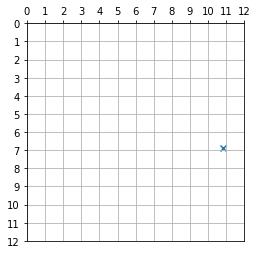

In [13]:
# grid's index
grid_ji = np.array([grid_j, grid_i], dtype=float)

# center of the box, measured from origin (top-left)
bx_xy_origin = bx_xy + grid_ji

print( 'center of the box in the {0}x{1} grid : ({2:.2f}, {3:.2f})'.format( *pred[0].shape[1:3], *bx_xy_origin ) )

'''Plot the center of the box in the grid'''
plt.figure()
plt.scatter(*bx_xy_origin, marker='x')
plt.xticks(np.arange(obj_scores.shape[1]))
plt.yticks(np.arange(obj_scores.shape[0]))
plt.gca().xaxis.tick_top()
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
ax = plt.gca()
plt.grid()
plt.show()

### Interpretation of the box parameters (width and height)
- Box parameter (w,h) indicates the how much to scale the anchor boxes
- Given, the width and height of anchor boxes be $w_a$ and $h_a$, respectively. The width and height of the detected bounding would be: $w_a*w$ and $h_a*h$, respectively.

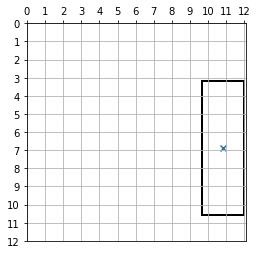

In [14]:
# bounding box's actual width and height
# (considering each grid cell's size is 1 unit)
bx_wh_origin = bx_wh * abox

'''Plot the bounding box in the grid'''
plt.figure()
plt.scatter(*bx_xy_origin, marker='x')
bx = mpl.patches.Rectangle(bx_xy_origin-bx_wh_origin/2, *bx_wh_origin, fill=False, lw=2)
plt.gca().add_patch(bx)
plt.xticks(np.arange(obj_scores.shape[1]))
plt.yticks(np.arange(obj_scores.shape[0]))
plt.gca().xaxis.tick_top()
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
ax = plt.gca()
plt.grid()
plt.show()

### Interpretation of the objectness score and conditional class probabilities
- Objectness score $p_0$ represents the probability of the presence of an object.
- Given an object present, $p_i$ represents the conditional probability of object belong to class $i$ (for $i$ = 1, ..., n).
- In other words, $p_0$ = P( object ), and $p_i$ = P( class = $i$ | object )
- Therefore,  
P( class = $i$ )  
= P( class = $i$ | object )$*$P( object )/$\sum_i$P( class = $i$ | object )$*$P( object )  
= $p_0*p_i$/$\sum_i$($p_0*p_i$)
- Final class, c = $\text{argmax}_i [(p_0*p_i)$/$\sum_i$($p_0*p_i$)] = $\text{argmax}_i (p_0*p_i)$
- $p_0*p_i$ is called the confidence score of the box

In [15]:
cls_id     = np.argmax( obj_score * cls_probs )
conf_score = obj_score * cls_probs[cls_id]

print( 'The predicted class of object inside the box is {}'.format( class_names[cls_id] ) )
print( 'The corresponding confidence score is {:.2f}'.format( conf_score[0] ) )

The predicted class of object inside the box is W
The corresponding confidence score is 1.00


### Rescale the boxes

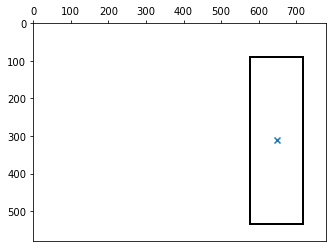

In [16]:
input_shape = np.array(input_shape).astype('float')
image_shape = np.array(image_shape).astype('float')
grid_shape  = np.array(grid_shape).astype('float')

# the resized new shape of the image
resized_shape = np.round( image_shape * np.min( input_shape / image_shape ) )

bx_offset = (image_shape.max() - image_shape) / 2.
bx_scale  = input_shape * image_shape / resized_shape / grid_shape

bx_xy_on_img = bx_xy_origin * bx_scale[::-1] - bx_offset[::-1]
bx_wh_on_img = bx_wh_origin * bx_scale[::-1]

'''Plot the bounding box in the grid'''
plt.figure()
plt.scatter( *bx_xy_on_img, marker='x' )
bx = mpl.patches.Rectangle( bx_xy_on_img-bx_wh_on_img/2, *bx_wh_on_img, fill=False, lw=2 )
plt.gca().add_patch(bx)
plt.xlim([0, image_shape[1]])
plt.ylim([0, image_shape[0]])
plt.gca().xaxis.tick_top()
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.show()

### Show on image

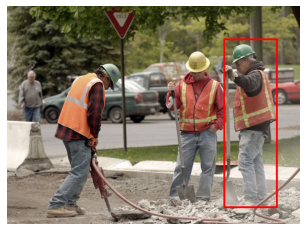

In [17]:
### Calculate top-left and bottom-right corner of the box
t,l = np.array( bx_xy_on_img - bx_wh_on_img/2 ).astype('int')
b,r = np.array( bx_xy_on_img + bx_wh_on_img/2 ).astype('int')

'''Show the image with the box'''
detected_img = cv2.rectangle(act_img, (t,l), (b,r), (0,0,255), 4)
plt.imshow( detected_img[:,:,::-1] )
plt.axis('off')
plt.show()

## **GET ALL BOXES**
Now let's get all the boxes @ the 1st output layers.

We will use tensors to calculate properties of the boxes altogether.

In [18]:
'''Inputs'''
output  = yolo_pred[0]
anchors = anchor_boxes[0]

In [19]:
'''Some preprocessing'''
grid_h, grid_w = output.shape[1:3] # grid_height, grid_width @ output layer

# reshape to [batch_size, grid_height, grid_width, num_anchors, box_params]
output = tf.reshape( output, [ -1, grid_h, grid_w, len(anchors), num_classes+5 ] )

# create a tensor for the anchor boxes
anchors_tensor = tf.constant(anchors, dtype=output.dtype)
anchors_tensor = tf.reshape( anchors_tensor, [1, 1, 1, len(anchors), 2] )

### **Geometric properties**

In [20]:
'''Grid positions'''
grid_i = tf.reshape( np.arange(grid_h), [-1, 1, 1, 1] )
grid_i = tf.tile( grid_i, [1, grid_w, 1, 1] )

grid_j = tf.reshape( np.arange(grid_w), [1, -1, 1, 1] )
grid_j = tf.tile( grid_j, [grid_h, 1, 1, 1] )

grid_ji = tf.concat( [grid_j, grid_i], axis=-1 )
grid_ji = tf.cast( grid_ji, output.dtype )

'''Box centers'''
box_xy  = output[..., 0:2]
box_xy  = tf.sigmoid( box_xy ) + grid_ji

'''Box sizes'''
box_wh  = output[..., 2:4]
box_wh  = tf.exp( box_wh ) * anchors_tensor

Let's see how do `grid_j`, `grid_i` and `box_xy` look like:

In [21]:
print('grid_j is the x-coordinates of the grid cells:\n')
print( grid_j[:,:,0,0].numpy().astype(int) )

print('\ngrid_i is the y-coordinates of the grid cells:\n')
print( grid_i[:,:,0,0].numpy().astype(int) )

np.set_printoptions(precision =2, suppress =True, linewidth=120)

print("\nbox_xy[...,0] is the x-coordinates of the boxes' centers:\n")
print( box_xy[:,:,:,0,0].numpy().astype(float) )

print("\nbox_xy[...,1] is the y-coordinates of the boxes' centers:\n")
print( box_xy[:,:,:,0,1].numpy().astype(float) )

grid_j is the x-coordinates of the grid cells:

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]]

grid_i is the y-coordinates of the grid cells:

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3  3  3  3]
 [ 4  4  4  4  4  4  4  4  4  4  4  4  4]
 [ 5  5  5  5  5  5  5  5  5  5  5  5  5]
 [ 6  6  6  6  6  6  6  6  6  6  6  6  6]
 [ 7  7  7  7  7  7  7  7  7  7  7  7  7]
 [ 8  8  8  8  8  8 

### **Probabilities**

In [22]:
'''Class and confidence scores'''
# class probabilities = objectness score * conditional class probabilities
classs_probs = tf.sigmoid( output[..., 4:5] ) * tf.sigmoid( output[..., 5:] )

# final classes
box_cl = tf.argmax( classs_probs, axis=-1 )

# confidence scores
box_sc = tf.reduce_max( classs_probs, axis=-1 )

`box_sc` indicates which cell might contain an object of interest. Let's see how does it look like:

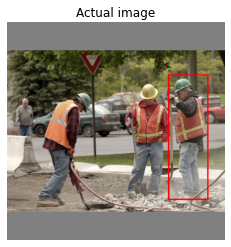

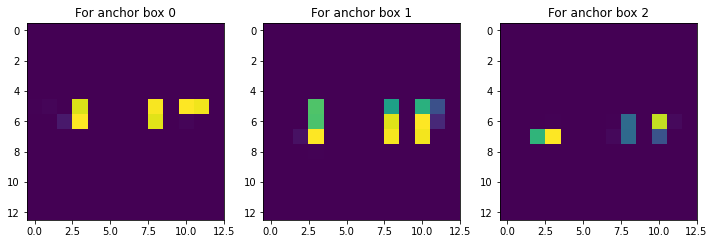

In [23]:
plt.figure(figsize=(4,4))
plt.imshow( letterbox_image(act_img, (416,416))[:,:,::-1] )
plt.axis('off')
plt.title('Actual image')
plt.show()

plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot('13'+str(i+1))
    plt.imshow( box_sc[0,:,:,i].numpy() )
    plt.title('For anchor box %s' % i)
plt.show()

### **Rescaling**

In [24]:
'''Get all the shapes'''
image_shape = tf.cast( image_shape,       output.dtype)  # actual image's shape
input_shape = tf.cast( input_shape,       output.dtype)  # yolo input image's shape
grids_shape = tf.cast( output.shape[1:3], output.dtype ) # grid_height, grid_width @ output layer

# the resized new shape of the image
# i.e. shape after resizing the image to fit 'input shape' without changing the aspect ratio
resized_shape = tf.round( image_shape * np.min( input_shape / image_shape ) )

'''Scaling factors'''
# to scale the boxes from grid's unit to actual image's pixel unit
box_scaling = input_shape * image_shape / resized_shape / grids_shape
# to offset the boxes
box_offsets = (tf.reduce_max(image_shape) - image_shape) / 2.

'''Scale to actual pixel unit'''
box_xy_on_img  = box_xy * box_scaling - box_offsets[::-1]
box_wh_on_img  = box_wh * box_scaling

'''Check boundaries'''
# calculate top-left and bottom-right corner of the boxex
box_tl = box_xy_on_img - box_wh_on_img/2
box_br = box_xy_on_img + box_wh_on_img/2

# top-left corner cannot be negative
box_tl = tf.maximum(0, box_tl)
box_tl = tf.cast( tf.round( box_tl ), dtype='int16' )
# bottom-right corner cannot be more than actual image size
box_br = tf.minimum(box_br, image_shape[::-1])
box_br = tf.cast( tf.round( box_br ), dtype='int16' )

### **Reorganizing**

In [25]:
boxes  = tf.reshape( tf.concat( [box_tl, box_br], axis=-1 ), [-1,4] )
labels = tf.reshape( box_cl, [-1] )
scores = tf.reshape( box_sc, [-1] )

### **Show on image**

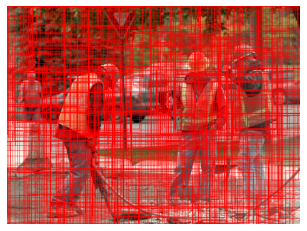

There are a total of 507 boxes!


In [26]:
'''Get the boxes with some non-zero confidence'''
idc = scores > 0 # indices
num_boxes = tf.math.count_nonzero(idc) # number of boxes

'''Put the rectangular boxes on the image'''
act_img = cv2.imread('../extras/sample-images/0.JPG')

for (t,l,b,r), class_id, conf in zip( boxes [idc].numpy(),
                                      labels[idc].numpy(),
                                      scores[idc].numpy()
                                    ):
    detected_img = cv2.rectangle(act_img, (t,l), (b,r), (0,0,255), 1)

plt.imshow( detected_img[:,:,::-1] )
plt.axis('off')
plt.show()

print('There are a total of {} boxes!'.format(num_boxes))

### **Non-max-suppression**
Most of the detected boxes are flase positive, reduntant, and/or duplicate of other boxes. To get rid of these boxes and to keep only the most confident boxes, we will use *non-max-suppression* (NMS) algorithm.


For each class:
1. First, get rid of all the boxes with confidence lower than a certain threshold (e.g. 0.3, or `score_threshold=0.3`).
2. a. Select each box in descending order of confidence level.\
b. Remove boxes that have high overlap (e.g. intersection-over-union, IoU > 0.45, or `iou_threshold=0.45`) with previously selected boxes.

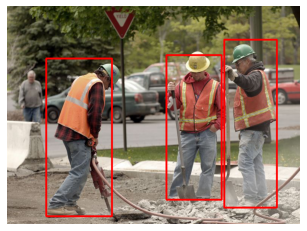

There are a total of 3 boxes for class W!


In [27]:
'''Get the boxes of the class labeled as <2>'''
class_boxes  = boxes [ labels==2 ]
class_boxes  = tf.cast(class_boxes, dtype='float')
class_scores = scores[ labels==2 ]

'''Non-max-suppression'''
idc = tf.image.non_max_suppression(
    class_boxes,
    class_scores,
    max_output_size=10,
    iou_threshold=0.45,
    score_threshold=0.3
)
num_boxes = tf.math.count_nonzero(idc) # number of boxes

'''Put the rectangular boxes on the image'''
act_img = cv2.imread('../extras/sample-images/0.JPG')

for (t,l,b,r), conf in zip( tf.gather( class_boxes,  idc),
                            tf.gather( scores, idc)
                          ):
    detected_img = cv2.rectangle(act_img, (t,l), (b,r), (0,0,255), 4)

plt.imshow( detected_img[:,:,::-1] )
plt.axis('off')
plt.show()

print('There are a total of {} boxes for class {}!'.format(num_boxes, class_names[2]))

## **CREATE A `tensorflow` FUNCTION**
Let's create a function that do everything we did so far.

In [28]:
def detection(
    prediction,
    anchor_boxes,
    num_classes,
    image_shape,
    input_shape,
    max_boxes = 20,
    score_threshold=0.3,
    iou_threshold=0.45,
    classes_can_overlap=True,
):
    '''
    INPUT:
    OUTPUT:
    '''
    
    all_boxes  = []

    '''@ Each output layer'''
    for output, anchors in zip( prediction, anchor_boxes ):

        '''Preprocessing'''
        '''-------------'''
        # shapes
        batch_size     = output.shape[0]
        grid_h, grid_w = output.shape[1:3]

        # reshape to [batch_size, grid_height, grid_width, num_anchors, box_params]
        output = tf.reshape( output, [ -1, grid_h, grid_w, len(anchors), num_classes+5 ] )

        # create a tensor for the anchor boxes
        anchors_tensor = tf.constant(anchors, dtype=output.dtype)

        '''Scaling factors'''
        '''---------------'''
        image_shape_tensor = tf.cast( image_shape,       output.dtype ) # actual image's shape
        grids_shape_tensor = tf.cast( output.shape[1:3], output.dtype ) # grid_height, grid_width @ output layer
        input_shape_tensor = tf.cast( input_shape,       output.dtype )  # yolo input image's shape

        # reshape
        image_shape_tensor = tf.reshape( image_shape_tensor, [-1, 1, 1, 1, 2] )
        grids_shape_tensor = tf.reshape( grids_shape_tensor, [-1, 1, 1, 1, 2] )
        input_shape_tensor = tf.reshape( input_shape_tensor, [-1, 1, 1, 1, 2] )

        ### Scaling factors
        sized_shape_tensor = tf.round( image_shape_tensor * tf.reshape( tf.reduce_min( input_shape_tensor / image_shape_tensor, axis=-1 ), [-1,1,1,1,1] ) )
        # to scale the boxes from grid's unit to actual image's pixel unit
        box_scaling = input_shape_tensor * image_shape_tensor / sized_shape_tensor / grids_shape_tensor
        # to offset the boxes
        box_offsets = (tf.expand_dims(tf.reduce_max(image_shape_tensor, axis=-1), axis=-1) - image_shape_tensor) / 2.

        '''Box geometric properties'''
        '''------------------------'''
        grid_h, grid_w = output.shape[1:3] # grid_height, grid_width @ output layer

        grid_i = tf.reshape( np.arange(grid_h), [-1, 1, 1, 1] )
        grid_i = tf.tile( grid_i, [1, grid_w, 1, 1] )

        grid_j = tf.reshape( np.arange(grid_w), [1, -1, 1, 1] )
        grid_j = tf.tile( grid_j, [grid_h, 1, 1, 1] )

        grid_ji = tf.concat( [grid_j, grid_i], axis=-1 )
        grid_ji = tf.cast( grid_ji, output.dtype )

        # Box centers
        box_xy  = output[..., 0:2]
        box_xy  = tf.sigmoid( box_xy ) + grid_ji

        # Box sizes
        box_wh  = output[..., 2:4]
        box_wh  = tf.exp( box_wh ) * anchors_tensor

        # scale to actual pixel unit
        box_xy  = box_xy * box_scaling - box_offsets[...,::-1]
        box_wh  = box_wh * box_scaling

        # calculate top-left corner (x1, y1) and bottom-right corner (x2, y2) of the boxex
        box_x1_y1 = box_xy - box_wh / 2
        box_x2_y2 = box_xy + box_wh / 2

        # top-left corner cannot be negative
        box_x1_y1 = tf.maximum(0, box_x1_y1)
        # bottom-right corner cannot be more than actual image size
        box_x2_y2 = tf.minimum(box_x2_y2, image_shape_tensor[..., ::-1])

        '''Box labels and confidences'''
        '''--------------------------'''
        # class probabilities = objectness score * conditional class probabilities
        if classes_can_overlap:
            # use sigmoid for the conditional class probabilities
            classs_probs = tf.sigmoid( output[..., 4:5] ) * tf.sigmoid( output[..., 5:] )
        else:
            # use softmax for the conditional class probabilities
            classs_probs = tf.sigmoid( output[..., 4:5] ) * tf.nn.softmax( output[..., 5:] )

        box_cl = tf.argmax( classs_probs, axis=-1 )     # final classes
        box_sc = tf.reduce_max( classs_probs, axis=-1 ) # confidence scores

        '''Organize'''
        '''--------'''
        # take care of dtype and dimensions
        box_cl = tf.cast( box_cl, output.dtype )
        box_cl = tf.expand_dims(box_cl, axis=-1)
        box_sc = tf.expand_dims(box_sc, axis=-1)

        # store all information as: [ left(x1), top(y1), right(x2), bottom(y2),  confidence, label ]
        boxes  = tf.reshape( tf.concat( [ box_x1_y1, box_x2_y2, box_sc, box_cl ], axis=-1 ), 
                              [batch_size, -1, 6] )

        all_boxes. append( boxes  )

    # Merge across all output layers
    all_boxes  = tf.concat( all_boxes,  axis=1 )

    # To store all the final results of all images in the batch
    all_final_boxes = []

    '''For each image in the batch'''
    for _boxes_ in all_boxes:

        if classes_can_overlap:
            '''Perform NMS for each class individually'''

            # to stote the final results of this image
            final_boxes = []

            for class_id in range(num_classes):

                # Get the boxes and scores for this class
                class_boxes  = _boxes_[ _boxes_[...,-1] == class_id ]

                '''Non-max-suppression'''
                selected_idc = tf.image.non_max_suppression(
                    class_boxes[...,:4], # boxes' (y1,x1,y2,x2)
                    class_boxes[...,-2], # boxes' scores
                    max_output_size = max_boxes,
                    iou_threshold = iou_threshold,
                    score_threshold = score_threshold
                )

                # boxes selected by nms
                class_boxes = tf.gather( class_boxes,  selected_idc )
                final_boxes.append( class_boxes )

            # concatenate boxes for each class in the image
            final_boxes  = tf.concat( final_boxes,  axis=0 )

        else:
            '''Perform NMS for all classes'''

            # nms indices
            selected_idc = tf.image.non_max_suppression(
                _boxes_[...,:4], # boxes' (y1,x1,y2,x2)
                _boxes_[...,-2], # boxes' scores
                max_output_size = max_boxes,
                iou_threshold = iou_threshold,
                score_threshold = score_threshold
            )
            
            # boxes selected by nms
            final_boxes = tf.gather( _boxes_,  selected_idc )

        # append final boxes for each image in the batch
        all_final_boxes.append( final_boxes )
        
    return all_final_boxes

### **See the function in action**

#### Single image

time taken to process : 119.63 ms


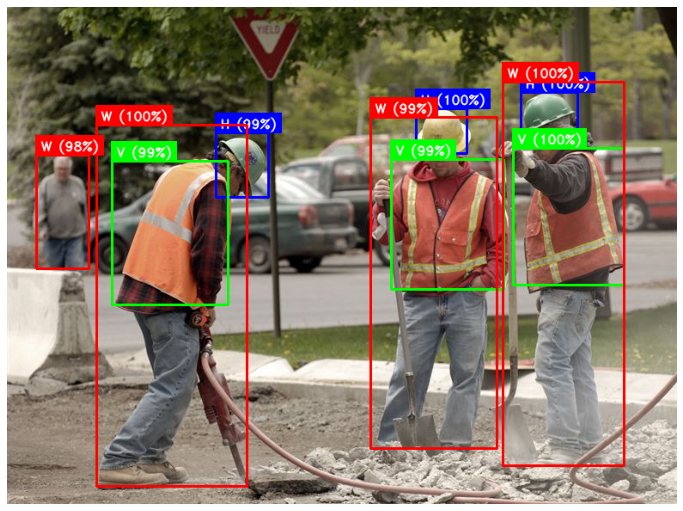

In [29]:
'''Get the image'''
image_data  = []
image_shape = []

act_img = cv2.imread( '../extras/sample-images/0.JPG' )
image_shape.append( act_img.shape[:-1] )
image_data.append( letterbox_image(act_img, (416,416))/255. )

image_data  = np.array( image_data  )
image_shape = np.array( image_shape )

'''Get the boxes'''
t0 = time() # set a timer

prediction = model.predict(image_data)

boxes = detection(
    prediction,
    anchor_boxes,
    num_classes,
    image_shape,
    input_shape = (416,416),
    max_boxes = 10,
    score_threshold=0.3,
    iou_threshold=0.45)

print('time taken to process : {:.2f} ms'.format( (time()-t0)*1000 ))

'''Draw the boxes'''
detected_img = draw_detection(act_img, boxes[0].numpy(), class_names)

plt.figure(figsize=(12,12))
plt.imshow( detected_img[:,:,::-1] )
plt.axis('off')
plt.show()

#### Multiple images in one batch
Paraller processing can reduce the processing time for each image.

time taken to process each image: 497.57 ms


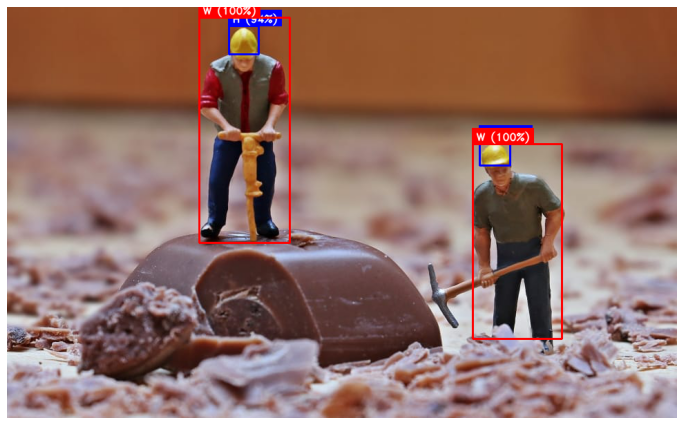

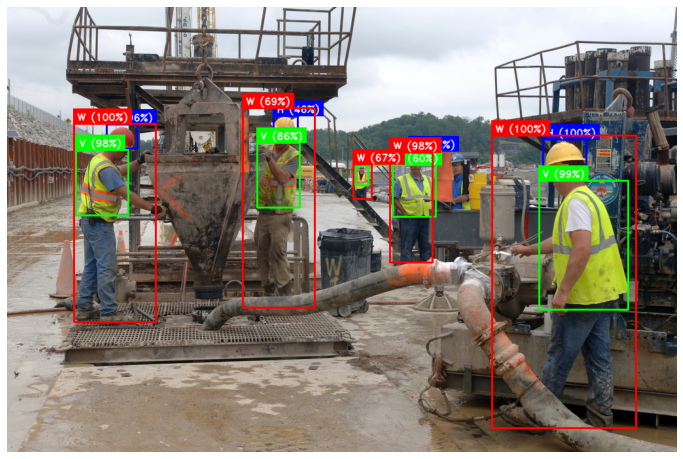

In [30]:
batch_size = 2

image_data  = []
image_shape = []

for i in range(batch_size):
    act_img = cv2.imread( f'../extras/sample-images/{i+1}.JPG' )
    image_shape.append( act_img.shape[:-1] )
    image_data.append( letterbox_image(act_img, (416,416))/255. )

image_data  = np.array( image_data  )
image_shape = np.array( image_shape )

'''Get the boxes'''
t0 = time() # set a timer

prediction = model.predict(image_data)

all_final_boxes = detection(
    prediction,
    anchor_boxes,
    num_classes,
    image_shape,
    input_shape = (416,416),
    max_boxes = 10,
    score_threshold=0.3,
    iou_threshold=0.45)

print('time taken to process each image: {:.2f} ms'.format( (time()-t0)*1000/batch_size ))

'''Draw the boxes'''
for i in range(batch_size):
    act_img = cv2.imread( f'../extras/sample-images/{i+1}.JPG' )
    detected_img = draw_detection(act_img, all_final_boxes[i].numpy(), class_names)

    plt.figure(figsize=(12, 12))
    plt.imshow( detected_img[:,:,::-1] )
    plt.axis('off')
    plt.show()